## Proyecto Final - Introducción a los Sistemas Inteligentes

# Evaluación de la generalización de un detector de imágenes falsas entrenado como parte de una GAN

## Andrés Ricardo Pérez Rojas - riperezro@unal.edu.co

## Febrero 9, 2022

Importamos la librerías y funciones necesarias

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Se recomienda ejecutar el notebook en un computador con una GPU disponible para reducir el tiempo que toma el entrenamiento de las redes. El siguiente comando verifica cuantas GPUs detecta tensorflow en el sistema. Si la GPU no es detectada, se recomienda verificar que se tenga instalado `tensorflow-gpu`. Si no se detecta una GPU de todas formas se puede ejecutar el notebook, pero los tiempos de entrenamiento serán significativamente más largos.

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importar el dataset Fashion MNIST al notebook

Primero, importemos el dataset FASHION MNIST desde Kaggle. Se debe tener la llave `kaggle.jason` en la misma carpeta que el notebook. En el caso de Google Colab, se debe subir la llave para poder importar el dataset directamente desde Kaggle. En los archivos entregados se incluye una llave.

In [1]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/andres/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download zalando-research/fashionmnist

Traceback (most recent call last):
  File "C:\Users\andre\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\andre\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\andre\anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\andre\anaconda3\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\andre\anaconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\andre\.kaggle. Or use the environment method.


In [ ]:
! unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


Usamos Pandas para cargar el csv como un Dataframe

In [ ]:
X = pd.read_csv('fashion-mnist_train.csv')
X.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Pre-procesamiento de los datos

Se escogen 3 clases para que sean anomalías. Estas clases representan casos de prendas reales para el experimento, y sirven para evaluar las generalización del detector mas allá de las clases en las que fue entrenado. Usamos una semmilla para el generador aleatorio para que el experimento sea replicable y podamos guardar la red entrenada al final.

In [ ]:
np.random.seed(0)

number_of_anomaly_classes = 3
anomaly_classes = np.random.choice(range(10), number_of_anomaly_classes, replace=False)
print( "anomaly classes =" , anomaly_classes )

anomaly classes = [2 8 4]


In [ ]:
X_anomalies = X.loc[X['label'].isin(anomaly_classes)]
X_anomalies.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [ ]:
X_not_anomalies = X.loc[~X['label'].isin(anomaly_classes)]
X_not_anomalies.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Tras escoger las anomalías, no necesitamos los valores de la columna "label", dado que el proceso de entrenamiento de una GAN es no supervisado. También transformamos los datos a un arreglo de numpy.

In [ ]:
X_anomalies = X_anomalies.drop('label', axis = 1).values
X_not_anomalies = X_not_anomalies.drop('label', axis = 1).values

Cambiamos la forma de los datos para llevarlos a la grilla de 28x28 de la imagen. Esto nos permite usar redes convolucionales.

In [ ]:
print(X_anomalies.shape)
X_anomalies = X_anomalies.reshape(-1,28,28,1)
print(X_anomalies.shape)

(18000, 784)
(18000, 28, 28, 1)


In [ ]:
print(X_not_anomalies.shape)
X_not_anomalies = X_not_anomalies.reshape(-1,28,28,1)
print(X_not_anomalies.shape)

(42000, 784)
(42000, 28, 28, 1)


Tenemos que normalizar y llevar los valores al rango (-1,1) dado que las redes GAN covolucionales tienen como función de activación tanh en la salida de la última capa del generador, y las imágenes deben estar en el mismo rango de salida de esta función.

In [ ]:
X_anomalies =  X_anomalies.astype('float32')
X_anomalies = X_anomalies/255
X_anomalies = X_anomalies*2 - 1.0
print(X_anomalies.max(),X_anomalies.min())

1.0 -1.0


In [ ]:
X_not_anomalies =  X_not_anomalies.astype('float32')
X_not_anomalies = X_not_anomalies/255
X_not_anomalies = X_not_anomalies*2 - 1.0
print(X_not_anomalies.max(),X_not_anomalies.min())

1.0 -1.0


Separamos los elementos que no son parte de las anomalías en subconjuntos de entrenaiento y de prueba.

In [ ]:
X_train, X_test = train_test_split(X_not_anomalies, test_size=0.1, random_state=1)
print( "X_train shape:", X_train.shape )
print( "X_test shape:", X_test.shape )

X_train shape: (37800, 28, 28, 1)
X_test shape: (4200, 28, 28, 1)


Podemos visualizar las imagenes originales de las clases elegidas como anomalias:

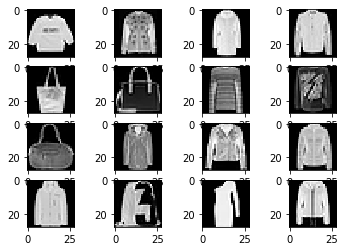

In [ ]:
grid_size = 4
fig,axe=plt.subplots(grid_size,grid_size)
for i in range(grid_size):
  for j in range(grid_size):
    axe[i,j].imshow(X_anomalies[i*grid_size+j].reshape(28,28),cmap='gray')

Y de las clases de entrenamiento que serán usadas para entrenar la GAN.

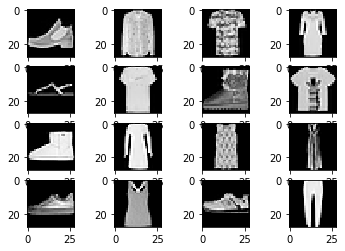

In [ ]:
grid_size = 4
fig,axe=plt.subplots(grid_size,grid_size)
for i in range(grid_size):
  for j in range(grid_size):
    axe[i,j].imshow(X_not_anomalies[i*grid_size+j].reshape(28,28),cmap='gray')

## Estructura de la primera red neuronal

Esta arquitectura de red fue tomada del notebook "Introduction to GANs on Fashion MNIST Dataset" de Kaggle, disponible en: https://www.kaggle.com/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset

Dado que el dominio de información en este caso son imagenes, se utulizarán redes convolucionales 2D que pueden interpretar y manejar mejor las estructras subyacentes de las imágenes.

En las redes GAN, el generador recibe como entrada ruido aleatorio. En este caso es un arreglo unidimensional cuya longitud se define a continuación.

In [ ]:
noise_shape = 100

Función que crea el generador

In [ ]:
def buildGenerator(noise_shape):
  generator = Sequential()
  generator.add(Dense(7 * 7 * 128, input_shape=[noise_shape]))
  generator.add(Reshape([7, 7, 128]))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                  activation="relu"))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                  activation="tanh"))
  return generator

In [ ]:
generator = buildGenerator(noise_shape)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

Podemos probar que en efecto el generador tome como entrada el ruido aleatrio de la longitud definida, y de como salida una imagen de las mismas diemsiones que las dataset original. Claramente las imagenes generadas antes del entrenamiento serán ruido, pero así verificamos la forma de la entrada y de la salida.

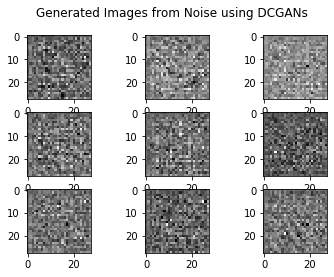

In [ ]:
noise = np.random.normal(loc=0, scale=1, size=(100,noise_shape))
gen_image = generator.predict(noise)

grid_size = 3
fig,axe=plt.subplots(grid_size,grid_size)
fig.suptitle('Generated Images from Noise using DCGANs')
for i in range(grid_size):
     for j in range(grid_size):
         axe[i,j].imshow(gen_image[i*grid_size+j].reshape(28,28),cmap='gray')

Función que crea el discriminador:

In [ ]:
def buildDiscriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                          activation=LeakyReLU(0.3),
                          input_shape=[28, 28, 1]))
  discriminator.add(Dropout(0.5))
  discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                          activation=LeakyReLU(0.3)))
  discriminator.add(Dropout(0.5))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation="sigmoid"))
  return discriminator

In [ ]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

Unimos el generador y el discriminador creados para construir la red GAN

In [ ]:
GAN = Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [ ]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
GAN.layers

In [ ]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


## Entrenamiento de la primera red neuronal

En cada iteración se debe entrenar tanto el generador como el discriminador. 

El discriminador es el más directo. Se generan imágenes con el generador que el discriminador debe identificar como falsas, y se escogen algunas imágenes del dataset de entrenamiento que debe identificar como verdaderas. De esta forma se tienen los ejemplos y sus correspondientes etiquetas para el entrenamiento.

El objetivo del generador es engañar al discriminador y que las imágenes generadas sean identificadas como verdaderas. Por ende, es necesario calcular su función de pérdida a partir del veredicto dado por el discriminador. Para este paso, se configura la red del discriminador como no entrenable, y se entrena la red GAN completa dandole como entrada ruido aleatorio y esperando como salida un veredicto de imagen verdadera.

El entrenamiento se debe realizar idealmente sobre una GPU para reducir su tiempo de ejecución.

In [ ]:
# Parametros para el entrenamiento
epochs = 150
batch_size = 100

Currently on Epoch 1
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378


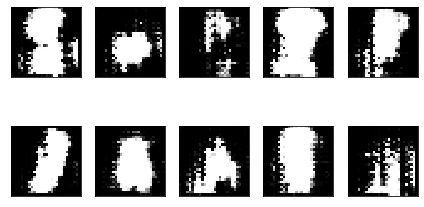

Currently on Epoch 2
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 3
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 4
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 5
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Current

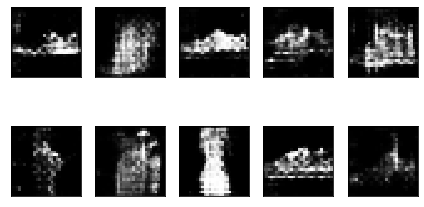

Currently on Epoch 12
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 13
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 14
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 15
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

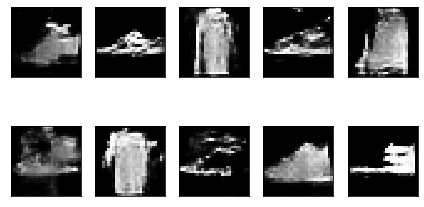

Currently on Epoch 22
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 23
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 24
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 25
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

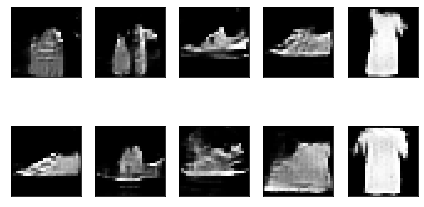

Currently on Epoch 32
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 33
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 34
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 35
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

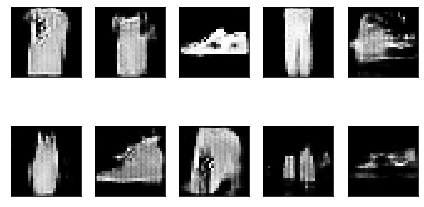

Currently on Epoch 42
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 43
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 44
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 45
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

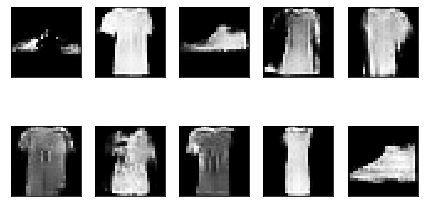

Currently on Epoch 52
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 53
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 54
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 55
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

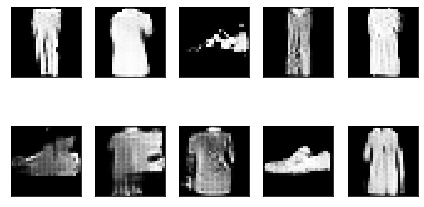

Currently on Epoch 62
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 63
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 64
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 65
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

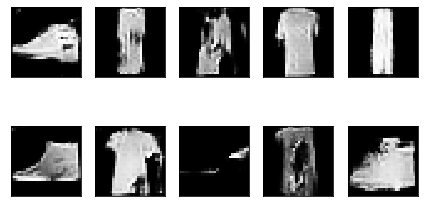

Currently on Epoch 72
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 73
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 74
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 75
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

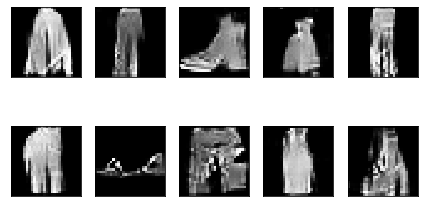

Currently on Epoch 82
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 83
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 84
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 85
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

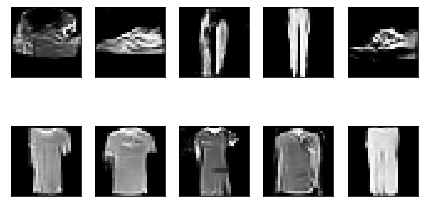

Currently on Epoch 92
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 93
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 94
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 95
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Cur

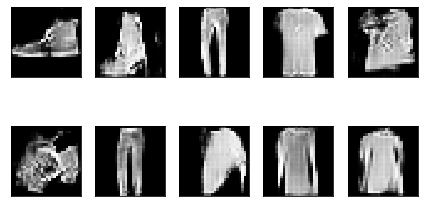

Currently on Epoch 102
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 103
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 104
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 105
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378


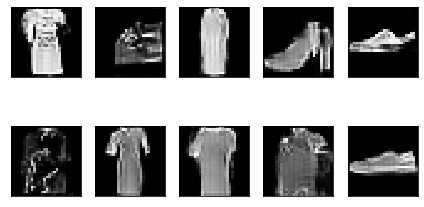

Currently on Epoch 112
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 113
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 114
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 115
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378


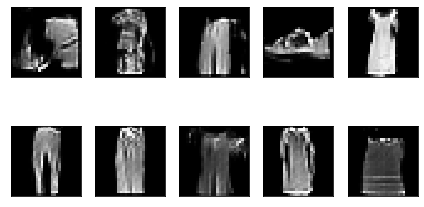

Currently on Epoch 122
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 123
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 124
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 125
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378


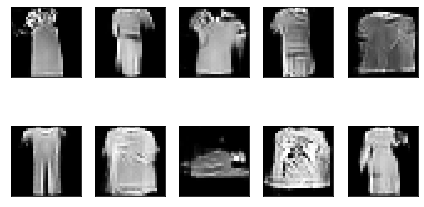

Currently on Epoch 132
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 133
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 134
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 135
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378


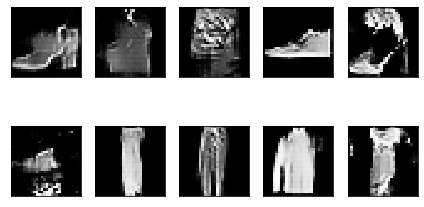

Currently on Epoch 142
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 143
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 144
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378
	Currently on batch number 200 of 378
	Currently on batch number 250 of 378
	Currently on batch number 300 of 378
	Currently on batch number 350 of 378
Currently on Epoch 145
	Currently on batch number 50 of 378
	Currently on batch number 100 of 378
	Currently on batch number 150 of 378


In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
        
        
       
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

        
        
print('Training is complete')

Exportaremos el modelo entrenado para poder usarlo en el futuro sin tener que entrenar desde cero la red nuevamente

In [ ]:
# Guardar los pesos de la red entrenada
GAN.save_weights('./model_weights/gan_1')

De la misma manera podemos importar los pesos de la red a partir de los pesos exportados

In [ ]:
# Descomentar la línea justo abajo para cargar los pesos guardados
#GAN.load_weights('./model_weights/gan_1')

Podemos comparar las imagenes generadas por la red con las imagenes originales del dataset de entrenamiento.

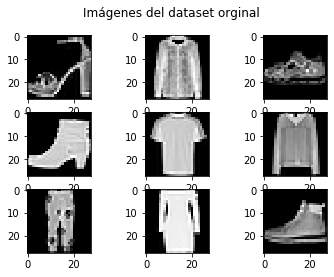

In [ ]:
grid_size = 3
fig,axe=plt.subplots(grid_size,grid_size)
fig.suptitle("Imágenes del dataset orginal")
for i in range(grid_size):
    for j in range(grid_size):
        axe[i,j].imshow(X_train[i*grid_size+j].reshape(28,28),cmap='gray')

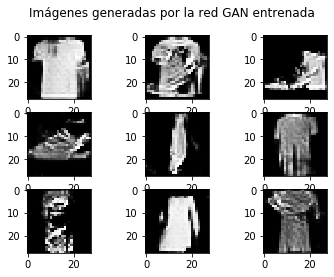

In [ ]:
noise = np.random.normal(loc=0, scale=1, size=(100,noise_shape))
gen_image = generator.predict(noise)

grid_size = 3
fig,axe=plt.subplots(grid_size,grid_size)
fig.suptitle('Imágenes generadas por la red GAN entrenada')
for i in range(grid_size):
    for j in range(grid_size):
         axe[i,j].imshow(gen_image[i*grid_size+j].reshape(28,28),cmap='gray')

## Evaluación de la generalización del detector

Hasta aquí nos hemos basado mucho en el notebook de kaggle "Introduction to GANs on Fashion MNIST Dataset" como referencia para construir la red GAN y entrenar el generador junto al discriminador.

Ahora pasamos al objetivo del proyecto: evaluar la generalización de un discriminador entrenado como parte de una GAN para distinguir imágenes reales de imagenes generadas o modificadas con redes neuronales.

Un discriminador de este estilo puede ser utilizado para evitar que los usuarios de una aplicación de ventas suban fotos falsas y alteradas.

Para las imágenes de prueba podemos usar el subconjunto del dataset separado para pruebas que no fueron utilizados en el entrenamiento, y las imágenes del dataset de las clases que fueron elegidas como anomalías.

Generamos una cantidad igual de imágenes con el generador entrenado para completar el dataset de pruebas.

In [ ]:
number_of_real_images = X_test.shape[0] + X_anomalies.shape[0]
print("number of real images =", number_of_real_images)

number of real images = 22200


In [ ]:
noise = np.random.normal(loc=0, scale=1, size=(number_of_real_images,noise_shape))
X_generated_images = generator.predict(noise)
print("number of generated images =",X_generated_images.shape[0])

number of generated images = 22200


Ahora se pasarán estas imágenes por el detector y a partir de las salidas se calcularán las medidas de desempeño.

In [ ]:
y_true = np.concatenate((
    np.ones(number_of_real_images),
    np.zeros(number_of_real_images)
    ), axis=None)
print(y_true.shape)

(44400,)


In [ ]:
y_test = discriminator.predict( X_test ) >= 0.5
y_anomalies = discriminator.predict( X_anomalies ) >= 0.5
y_generated_images = discriminator.predict( X_generated_images ) >= 0.5

y_pred = np.concatenate((
    y_test,
    y_anomalies,
    y_generated_images
    ), axis=None)
print(y_pred.shape)

(44400,)


Generamos el reporte con Scikit Learn

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.82      0.69     22200
         1.0       0.71      0.44      0.54     22200

    accuracy                           0.63     44400
   macro avg       0.65      0.63      0.61     44400
weighted avg       0.65      0.63      0.61     44400



[Text(0, 0.5, 'Generada'), Text(0, 1.5, 'Real')]

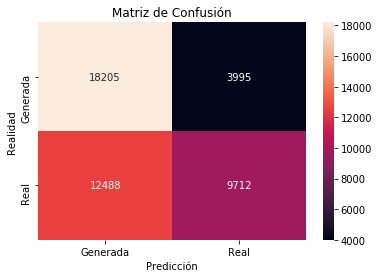

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicción');ax.set_ylabel('Realidad'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Generada', 'Real']); ax.yaxis.set_ticklabels(['Generada', 'Real'])

Podemos evaluar también el desempeño del discriminador para cada posible origen de la entrada.

Para empezar, evaluemos su desempeño con las imágenes generadas:

In [ ]:
print(classification_report(np.zeros( len(y_generated_images) ),y_generated_images))

              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90     22200
         1.0       0.00      0.00      0.00         0

    accuracy                           0.82     22200
   macro avg       0.50      0.41      0.45     22200
weighted avg       1.00      0.82      0.90     22200



/home/andres/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Para las imágenes del dataset de pruebas:

In [ ]:
print(classification_report(np.ones( len(y_test) ),y_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.46      0.63      4200

    accuracy                           0.46      4200
   macro avg       0.50      0.23      0.31      4200
weighted avg       1.00      0.46      0.63      4200



Y finalemente para la clases elegidas como anomalías:

In [ ]:
print(classification_report(np.ones( len(y_anomalies) ),y_anomalies))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.43      0.60     18000

    accuracy                           0.43     18000
   macro avg       0.50      0.22      0.30     18000
weighted avg       1.00      0.43      0.60     18000



## Estructura de la segunda red neuronal

Esta arquitectura de red fue tomada del notebook "Introduction to GANs with Keras" de Kaggle, disponible en: https://www.kaggle.com/yushg123/introduction-to-gans-with-keras

Dado que el dominio de información en este caso son imagenes, se utulizarán redes convolucionales 2D que pueden interpretar y manejar mejor las estructras subyacentes de las imágenes.

Función que crea el generador

In [ ]:
def buildGenerator_v2(noise_shape):
  generator = Sequential() 
  d = 7
  generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_shape))
  generator.add(LeakyReLU(0.2))
  
  generator.add(Reshape((d, d, 256)))
  
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))

  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  generator.add(Conv2D(1, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
  
  generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
  return generator

In [ ]:
generator_v2 = buildGenerator_v2(noise_shape)
generator_v2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       524416    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

Podemos probar que en efecto el generador tome como entrada el ruido aleatrio de la longitud definida, y de como salida una imagen de las mismas diemsiones que las dataset original. Claramente las imagenes generadas antes del entrenamiento serán ruido, pero así verificamos la forma de la entrada y de la salida.

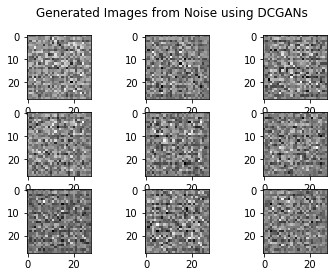

In [ ]:
noise = np.random.normal(loc=0, scale=1, size=(100,noise_shape))
gen_image = generator_v2.predict(noise)

grid_size = 3
fig,axe=plt.subplots(grid_size,grid_size)
fig.suptitle('Generated Images from Noise using DCGANs')
for i in range(grid_size):
     for j in range(grid_size):
         axe[i,j].imshow(gen_image[i*grid_size+j].reshape(28,28),cmap='gray')

Función que crea el discriminador

In [ ]:
def buildDiscriminator_v2():
  discriminator = Sequential()
  
  discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(28, 28, 1)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid', input_shape=(28, 28, 1)))
  
  discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))  #Again, the loss doesn't change when creating a DCGAN.
  return discriminator

In [ ]:
discriminator_v2 = buildDiscriminator_v2()
discriminator_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)        

Unimos el generador y el discriminador para construir la red GAN

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

discriminator_v2.trainable = False

GAN_v2_input = Input(shape=(noise_shape))
fake_image = generator_v2(GAN_v2_input)
GAN_v2_output = discriminator_v2(fake_image)

GAN_v2 = Model(GAN_v2_input, GAN_v2_output)
GAN_v2.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [ ]:
GAN_v2.layers

In [ ]:
GAN_v2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         2054785   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 521345    
Total params: 2,576,130
Trainable params: 2,054,785
Non-trainable params: 521,345
_________________________________________________________________


## Entrenamiento de la segunda red neuronal

Entrenamos la red de manera muy parecida a la primera.

En cada iteración se debe entrenar tanto el generador como el discriminador. 

El discriminador es el más directo. Se generan imágenes con el generador que el discriminador debe identificar como falsas, y se escogen algunas imágenes del dataset de entrenamiento que debe identificar como verdaderas. De esta forma se tienen los ejemplos y sus correspondientes etiquetas para el entrenamiento.

El objetivo del generador es engañar al discriminador y que las imágenes generadas sean identificadas como verdaderas. Por ende, es necesario calcular su función de pérdida a partir del veredicto dado por el discriminador. Para este paso, se configura la red del discriminador como no entrenable, y se entrena la red GAN completa dandole como entrada ruido aleatorio y esperando como salida un veredicto de imagen verdadera.

El entrenamiento se debe realizar idealmente sobre una GPU para reducir su tiempo de ejecución.

In [ ]:
# Parametros para el entrenamiento
epochs = 10
batch_size = 16
steps_per_epoch = 3750

Currently on Epoch 1
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


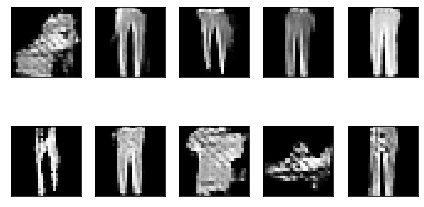

Currently on Epoch 2
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


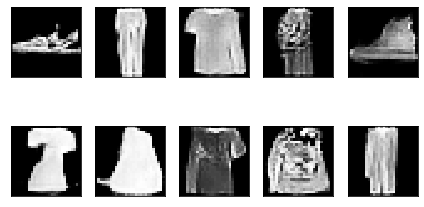

Currently on Epoch 3
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


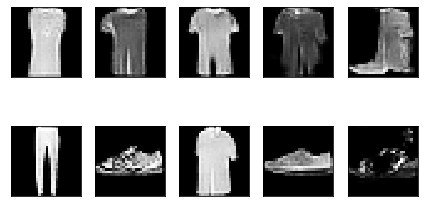

Currently on Epoch 4
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


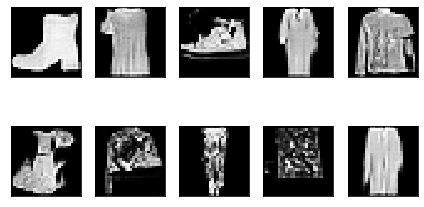

Currently on Epoch 5
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


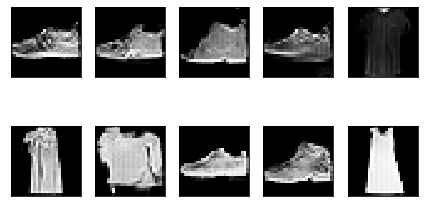

Currently on Epoch 6
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


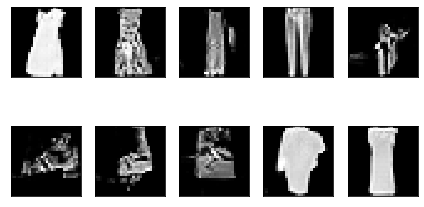

Currently on Epoch 7
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


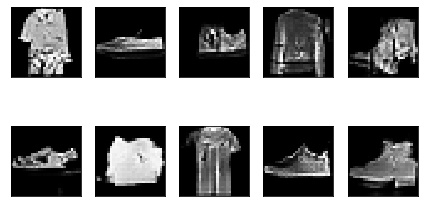

Currently on Epoch 8
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


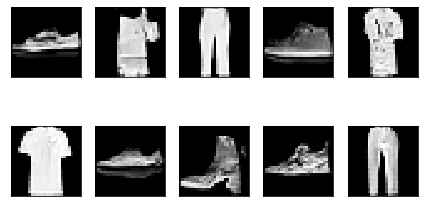

Currently on Epoch 9
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


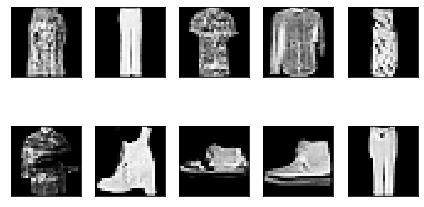

Currently on Epoch 10
	Currently on batch number 250 of 3750
	Currently on batch number 500 of 3750
	Currently on batch number 750 of 3750
	Currently on batch number 1000 of 3750
	Currently on batch number 1250 of 3750
	Currently on batch number 1500 of 3750
	Currently on batch number 1750 of 3750
	Currently on batch number 2000 of 3750
	Currently on batch number 2250 of 3750
	Currently on batch number 2500 of 3750
	Currently on batch number 2750 of 3750
	Currently on batch number 3000 of 3750
	Currently on batch number 3250 of 3750
	Currently on batch number 3500 of 3750
	Currently on batch number 3750 of 3750


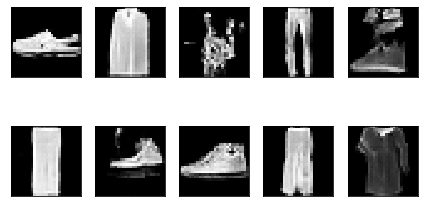

Training is complete


In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    for batch in range(steps_per_epoch):
        if (batch+1)%250 == 0:
            print(f"\tCurrently on batch number {batch+1} of {steps_per_epoch}")
        noise = np.random.normal(0, 1, size=(batch_size, noise_shape))
        fake_x = generator_v2.predict(noise)

        real_x = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        discriminator_v2.trainable = True
        d_loss = discriminator_v2.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        discriminator_v2.trainable = False
        g_loss = GAN_v2.train_on_batch(noise, y_gen)
    
    samples = 10
    x_fake = generator_v2.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

    for k in range(samples):
        plt.subplot(2, 5, k+1)
        plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()
        
        
print('Training is complete')

Exportaremos el modelo entrenado para poder usarlo en el futuro sin tener que entrenar desde cero la red nuevamente

In [ ]:
# Guardar los pesos de la red entrenada
GAN_v2.save_weights('./model_weights/gan_2')

De la misma manera podemos importar los pesos de la red a partir de los pesos exportados

In [ ]:
# Descomentar la línea justo abajo para cargar los pesos guardados
# GAN.load_weights('./model_weights/gan_2')

Podemos comparar las imagenes generadas por la red con las imagenes originales del dataset de entrenamiento.

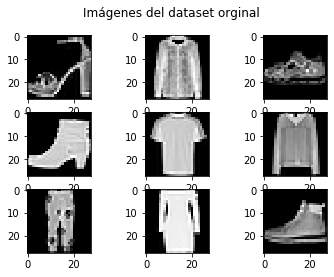

In [ ]:
grid_size = 3
fig,axe=plt.subplots(grid_size,grid_size)
fig.suptitle("Imágenes del dataset orginal")
for i in range(grid_size):
    for j in range(grid_size):
        axe[i,j].imshow(X_train[i*grid_size+j].reshape(28,28),cmap='gray')

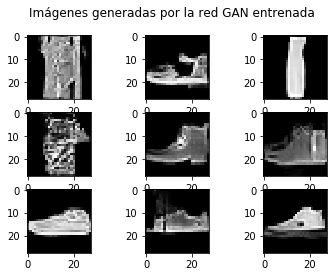

In [ ]:
noise = np.random.normal(loc=0, scale=1, size=(100,noise_shape))
gen_image = generator_v2.predict(noise)

grid_size = 3
fig,axe=plt.subplots(grid_size,grid_size)
fig.suptitle('Imágenes generadas por la red GAN entrenada')
for i in range(grid_size):
    for j in range(grid_size):
         axe[i,j].imshow(gen_image[i*grid_size+j].reshape(28,28),cmap='gray')

## Evaluación del segundo detector
Evaluaremos este detector de la misma manera en la que evaluamos el primero, para ver cual tiene mejor desempeño y generaliza mejor en muestras diferentes a las de entrenamiento.

Para las imágenes de prueba podemos usar el subconjunto del dataset separado para pruebas que no fueron utilizados en el entrenamiento, y las imágenes del dataset de las clases que fueron elegidas como anomalías.

Generamos una cantidad igual de imágenes con el generador entrenado para completer el dataset de pruebas.

In [ ]:
number_of_real_images = X_test.shape[0] + X_anomalies.shape[0]
print("number of real images =", number_of_real_images)

number of real images = 22200


In [ ]:
noise = np.random.normal(loc=0, scale=1, size=(number_of_real_images,noise_shape))
X_generated_images = generator_v2.predict(noise)
print("number of generated images =",X_generated_images.shape[0])

number of generated images = 22200


Ahora se pasarán estas imágenes por el detector y a partir de las salidas se calcularán las medidas de desempeño.

In [ ]:
y_true = np.concatenate((
    np.ones(number_of_real_images),
    np.zeros(number_of_real_images)
    ), axis=None)
print(y_true.shape)

(44400,)


In [ ]:
y_test = discriminator_v2.predict( X_test ) >= 0.5
y_anomalies = discriminator_v2.predict( X_anomalies ) >= 0.5
y_generated_images = discriminator_v2.predict( X_generated_images ) >= 0.5

y_pred = np.concatenate((
    y_test,
    y_anomalies,
    y_generated_images
    ), axis=None)
print(y_pred.shape)

(44400,)


Generamos el reporte con Scikit Learn

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.94      0.79     22200
         1.0       0.91      0.57      0.70     22200

    accuracy                           0.76     44400
   macro avg       0.80      0.76      0.75     44400
weighted avg       0.80      0.76      0.75     44400



[Text(0, 0.5, 'Generada'), Text(0, 1.5, 'Real')]

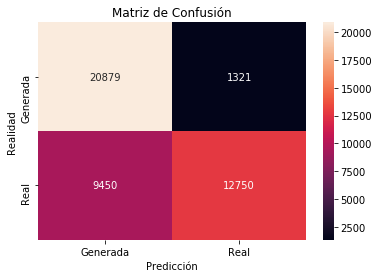

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicción');ax.set_ylabel('Realidad'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Generada', 'Real']); ax.yaxis.set_ticklabels(['Generada', 'Real'])

Podemos evaluar también el desempeño del discriminador para cada posible origen de la entrada.

Para empezar, evaluemos su desempeño con las imágenes generadas:

In [ ]:
print(classification_report(np.zeros( len(y_generated_images) ),y_generated_images))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     22200
         1.0       0.00      0.00      0.00         0

    accuracy                           0.94     22200
   macro avg       0.50      0.47      0.48     22200
weighted avg       1.00      0.94      0.97     22200



Para las imágenes del dataset de pruebas:

In [ ]:
print(classification_report(np.ones( len(y_test) ),y_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.61      0.75      4200

    accuracy                           0.61      4200
   macro avg       0.50      0.30      0.38      4200
weighted avg       1.00      0.61      0.75      4200



Y finalemente para la clases elegidas como anomalías:

In [ ]:
print(classification_report(np.ones( len(y_anomalies) ),y_anomalies))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.57      0.72     18000

    accuracy                           0.57     18000
   macro avg       0.50      0.28      0.36     18000
weighted avg       1.00      0.57      0.72     18000



## Desempeño con imágenes generadas por la otra red

Dado que entrenamos dos redes GAN diferentes con el mismo dataset, también podemos evaluar el desempeño de cada discriminador con imágenes generadas con un generador diferente al que fue usado en su entrenamiento

Primero, evaluemos el desempeño del primer discriminador con imágenes generadas por el segundo generador

In [ ]:
number_of_samples = 10000

noise = np.random.normal(loc=0, scale=1, size=(number_of_samples,noise_shape))
X_generated_images = generator_v2.predict(noise)
print("number of generated images =",X_generated_images.shape[0])

number of generated images = 10000


In [ ]:
y_generated_images = discriminator.predict( X_generated_images ) >= 0.5

In [ ]:
print(classification_report(np.zeros( len(y_generated_images) ),y_generated_images))

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88     10000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.79     10000
   macro avg       0.50      0.39      0.44     10000
weighted avg       1.00      0.79      0.88     10000



/home/andres/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ahora, evaluemos el desempeño del segundo discriminador con imágenes generadas por el primer generador

In [ ]:
number_of_samples = 10000

noise = np.random.normal(loc=0, scale=1, size=(number_of_samples,noise_shape))
X_generated_images = generator.predict(noise)
print("number of generated images =",X_generated_images.shape[0])

number of generated images = 10000


In [ ]:
y_generated_images = discriminator_v2.predict( X_generated_images ) >= 0.5

In [ ]:
print(classification_report(np.zeros( len(y_generated_images) ),y_generated_images))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10000
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000

